<a href="https://colab.research.google.com/github/mm79Code/LROPTI_CNN/blob/main/Covid_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Learning Rate = Cyclic Based**

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/MyDrive/Need/Up/Mash/Updated/Covid19-dataset/train'

Normal_dir = os.path.join(base_dir, 'Normal')
Covid_dir = os.path.join(base_dir, 'Covid')
Viral_Pneumonia_dir = os.path.join(base_dir, 'Viral Pneumonia')

print('total training Normal images:', len(os.listdir(Normal_dir)))
print('total training Covid images:', len(os.listdir(Covid_dir)))
print('total training Viral Pneumonia images:', len(os.listdir(Viral_Pneumonia_dir)))

Normal_files = os.listdir(Normal_dir)
print(Normal_files[:10])

Covid_files = os.listdir(Covid_dir)
print(Covid_files[:10])

Viral_Pneumonia_files = os.listdir(Viral_Pneumonia_dir)
print(Viral_Pneumonia_files[:10])

total training Normal images: 70
total training Covid images: 111
total training Viral Pneumonia images: 70
['019.jpeg', '018.jpeg', '010.jpeg', '011.jpeg', '017.jpeg', '016.jpeg', '01.jpeg', '015.jpeg', '014.jpeg', '012.jpeg']
['015.jpg', '019.png', '010.png', '02.jpeg', '012.jpeg', '01.jpeg', '042.jpeg', '040.jpeg', '031.jpeg', '03.jpeg']
['035.jpeg', '032.jpeg', '044.jpeg', '020.jpeg', '01.jpeg', '010.jpeg', '048.jpeg', '04.jpeg', '02.jpeg', '023.jpeg']


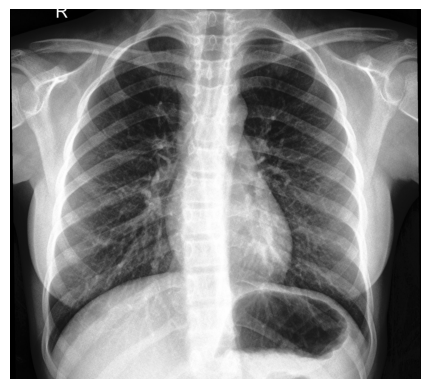

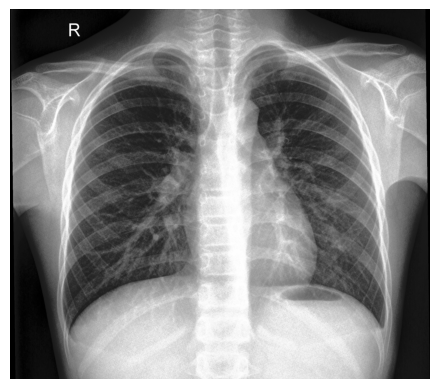

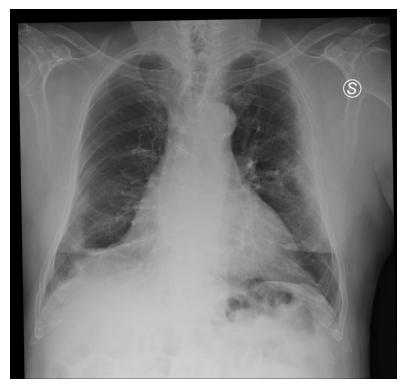

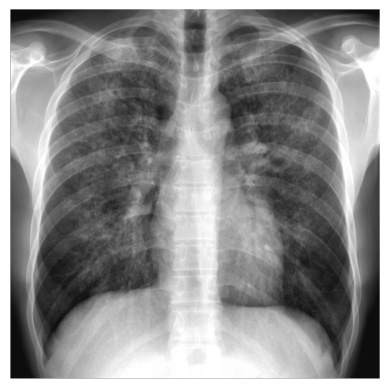

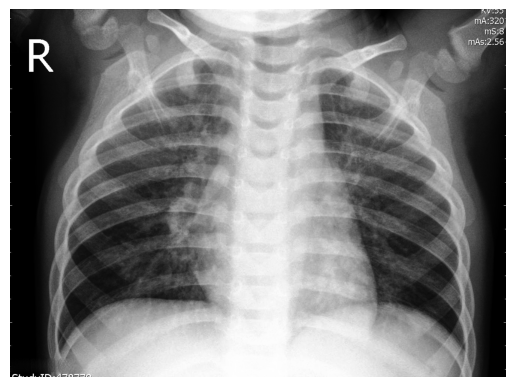

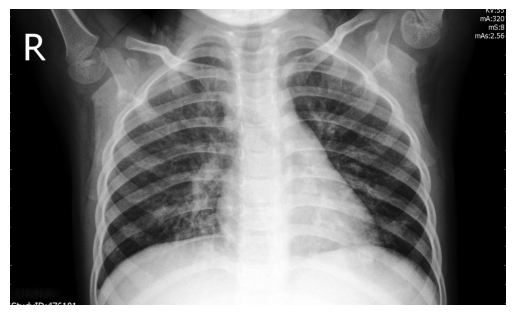

In [ ]:
import matplotlib.image as mpimg
pic_index = 2

next_Normal = [os.path.join(Normal_dir, fname)
                for fname in Normal_files[pic_index-2:pic_index]]
next_Covid = [os.path.join(Covid_dir, fname)
                for fname in Covid_files[pic_index-2:pic_index]]
next_Viral_Pneumonia = [os.path.join(Viral_Pneumonia_dir, fname)
                for fname in Viral_Pneumonia_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_Normal+next_Covid+next_Viral_Pneumonia):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [ ]:
train_dir = '/content/drive/MyDrive/Need/Up/Mash/Updated/Covid19-dataset/train'
train_datagen = ImageDataGenerator(rescale = 1./255,
	    rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

validation_dir = '/content/drive/MyDrive/Need/Up/Mash/Updated/Covid19-dataset/test'
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
	train_dir,
	target_size=(255,255),
	class_mode='categorical',
  batch_size=64
)

validation_generator = validation_datagen.flow_from_directory(
	validation_dir,
	target_size=(255,255),
	class_mode='categorical',
  batch_size=16
)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


### **Model Implementation**

In [ ]:
# Model Definition
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(255, 255, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 253, 253, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 126, 126, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)       

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
epoch = 100

### **Learning Rate**

In [ ]:
def cyclic_lr(epoch, lr):
    base_lr = 1e-4
    max_lr = 1e-3

    # Dynamic step_size based on the training data and batch size
    total_training_images = 70 + 111 + 70
    batch_size = 64
    iterations_per_epoch = math.ceil(total_training_images / batch_size)
    multiplier = 2
    step_size = iterations_per_epoch * multiplier

    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    new_lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1 - x))
    return new_lr

lr_scheduler = LearningRateScheduler(cyclic_lr)

### **Optimizer = Adam**

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=epoch,
                    steps_per_epoch=3,
                    validation_data = validation_generator,
                    verbose = 1, validation_steps=3, callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
3/3 [==============================] - 12s 3s/step - loss: 0.3614 - accuracy: 0.8342 - val_loss: 0.7741 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 2/100
3/3 [==============================] - 8s 3s/step - loss: 0.3396 - accuracy: 0.8556 - val_loss: 0.6121 - val_accuracy: 0.7708 - lr: 2.1250e-04
Epoch 3/100
3/3 [==============================] - 9s 3s/step - loss: 0.3566 - accuracy: 0.8698 - val_loss: 0.5908 - val_accuracy: 0.7500 - lr: 3.2500e-04
Epoch 4/100
3/3 [==============================] - 10s 4s/step - loss: 0.4307 - accuracy: 0.8128 - val_loss: 0.7945 - val_accuracy: 0.6667 - lr: 4.3750e-04
Epoch 5/100
3/3 [==============================] - 9s 3s/step - loss: 0.4366 - accuracy: 0.8342 - val_loss: 0.5315 - val_accuracy: 0.7708 - lr: 5.5000e-04
Epoch 6/100
3/3 [==============================] - 9s 3s/step - loss: 0.5300 - accuracy: 0.7540 - val_loss: 0.8277 - val_accuracy: 0.6250 - lr: 6.6250e-04
Epoch 7/100
3/3 [==============================] - 9s 3s/step - loss

In [ ]:
epochs_completed = len(history.history['loss'])
print(f"Training stopped at epoch: {epochs_completed}")

Training stopped at epoch: 25


In [ ]:
Adam_loss = history.history['loss']
Adam_acc = history.history['accuracy']

print(Adam_loss)
print(Adam_acc)

[0.3614116907119751, 0.33955344557762146, 0.35663387179374695, 0.4307458996772766, 0.4365583658218384, 0.5299841165542603, 0.4555259048938751, 0.446064829826355, 0.4518103003501892, 0.3082308769226074, 0.3662968575954437, 0.31866252422332764, 0.3686971664428711, 0.2501225471496582, 0.3331206142902374, 0.27258923649787903, 0.2172924131155014, 0.28125277161598206, 0.2716129422187805, 0.30884143710136414, 0.19074209034442902, 0.27813246846199036, 0.3512626588344574, 0.3515886962413788, 0.37505581974983215]
[0.8342245817184448, 0.855614960193634, 0.8697916865348816, 0.8128342032432556, 0.8342245817184448, 0.7540106773376465, 0.8609625697135925, 0.8395721912384033, 0.7914438247680664, 0.8823529481887817, 0.8609625697135925, 0.8823529481887817, 0.8541666865348816, 0.9090909361839294, 0.8770053386688232, 0.866310179233551, 0.8983957171440125, 0.8983957171440125, 0.9090909361839294, 0.8770053386688232, 0.9304812550544739, 0.8877005577087402, 0.8541666865348816, 0.8716577291488647, 0.8342245817

In [ ]:
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)
print(f"Optimizer: Adam, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Optimizer: Adam, Validation Loss: 0.49416184425354004, Validation Accuracy: 0.7575757503509521


In [ ]:
loss, accuracy = model.evaluate(train_generator, verbose=0)
print(f"Optimizer: Adam, Training Loss: {loss}, Training Accuracy: {accuracy}")

Optimizer: Adam, Training Loss: 0.2829163074493408, Training Accuracy: 0.8964143395423889


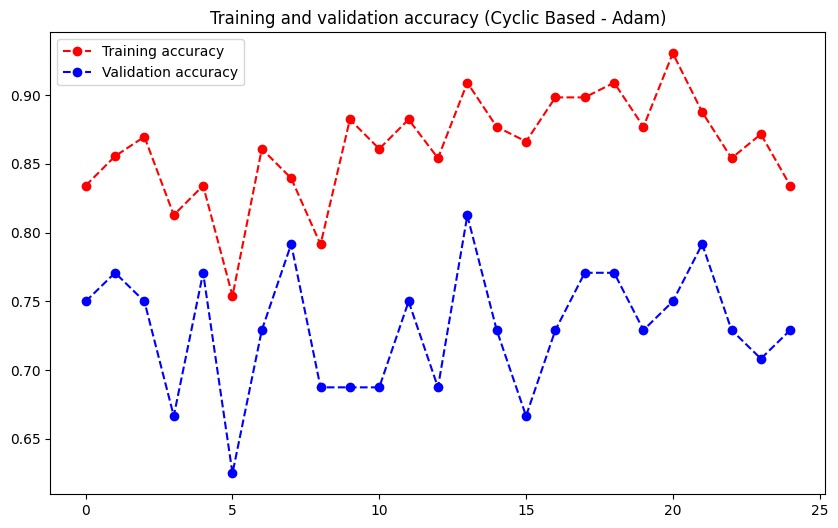

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'r', label='Training accuracy', marker = 'o', linestyle = 'dashed')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy', marker = 'o', linestyle = 'dashed')
plt.title('Training and validation accuracy (Cyclic Based - Adam)')
plt.legend(loc=0)

plt.show()

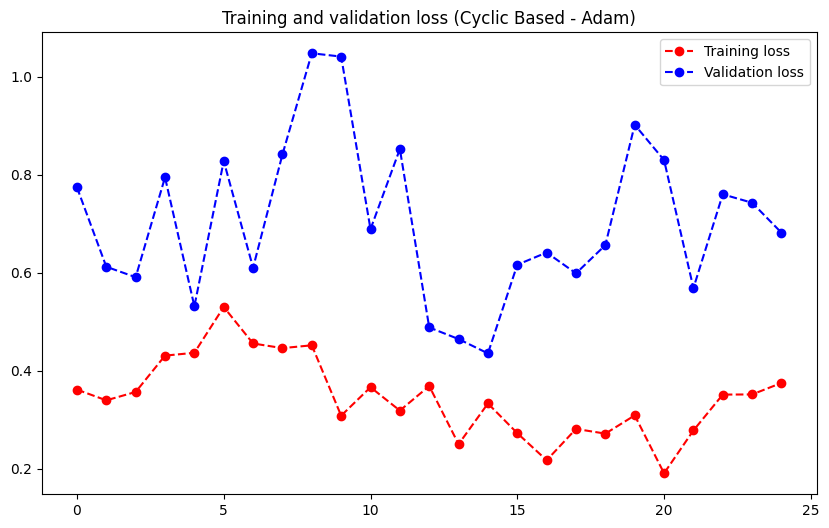

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'r', label='Training loss', marker = 'o', linestyle = 'dashed')
plt.plot(epochs, val_loss, 'b', label='Validation loss', marker = 'o', linestyle = 'dashed')
plt.title('Training and validation loss (Cyclic Based - Adam)')
plt.legend(loc=0)

plt.show()

### **Optimizer = Adagrad**

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer=Adagrad(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=epoch,
                    steps_per_epoch=3,
                    validation_data = validation_generator,
                    verbose = 1, validation_steps=3, callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
3/3 [==============================] - 12s 4s/step - loss: 0.3169 - accuracy: 0.8717 - val_loss: 0.4190 - val_accuracy: 0.7292 - lr: 1.0000e-04
Epoch 2/100
3/3 [==============================] - 9s 3s/step - loss: 0.3120 - accuracy: 0.8877 - val_loss: 0.4704 - val_accuracy: 0.7292 - lr: 2.1250e-04
Epoch 3/100
3/3 [==============================] - 10s 4s/step - loss: 0.2901 - accuracy: 0.8698 - val_loss: 0.4451 - val_accuracy: 0.7292 - lr: 3.2500e-04
Epoch 4/100
3/3 [==============================] - 8s 3s/step - loss: 0.3363 - accuracy: 0.8610 - val_loss: 0.5717 - val_accuracy: 0.7292 - lr: 4.3750e-04
Epoch 5/100
3/3 [==============================] - 9s 4s/step - loss: 0.2817 - accuracy: 0.8610 - val_loss: 0.4149 - val_accuracy: 0.7083 - lr: 5.5000e-04
Epoch 6/100
3/3 [==============================] - 9s 3s/step - loss: 0.3072 - accuracy: 0.8824 - val_loss: 0.4907 - val_accuracy: 0.7500 - lr: 6.6250e-04
Epoch 7/100
3/3 [==============================] - 8s 3s/step - loss

In [ ]:
epochs_completed = len(history.history['loss'])
print(f"Training stopped at epoch: {epochs_completed}")

Training stopped at epoch: 17


In [ ]:
Adagrad_loss = history.history['loss']
Adagrad_acc = history.history['accuracy']

print(Adagrad_loss)
print(Adagrad_acc)

[0.31685951352119446, 0.31199949979782104, 0.29012367129325867, 0.3363349139690399, 0.28172191977500916, 0.30719342827796936, 0.2756909430027008, 0.2969169616699219, 0.30771902203559875, 0.2903672754764557, 0.295019268989563, 0.24078787863254547, 0.2471027821302414, 0.227569118142128, 0.24609078466892242, 0.2788848876953125, 0.23317888379096985]
[0.8716577291488647, 0.8877005577087402, 0.8697916865348816, 0.8609625697135925, 0.8609625697135925, 0.8823529481887817, 0.8770053386688232, 0.8823529481887817, 0.875, 0.8716577291488647, 0.8716577291488647, 0.9010416865348816, 0.893048107624054, 0.8983957171440125, 0.8983957171440125, 0.8958333134651184, 0.9197860956192017]


In [ ]:
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)
print(f"Optimizer: Adagrad, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Optimizer: Adagrad, Validation Loss: 0.49183106422424316, Validation Accuracy: 0.7575757503509521


In [ ]:
loss, accuracy = model.evaluate(train_generator, verbose=0)
print(f"Optimizer: Adagrad, Training Loss: {loss}, Training Accuracy: {accuracy}")

Optimizer: Adagrad, Training Loss: 0.2592621147632599, Training Accuracy: 0.9083665609359741


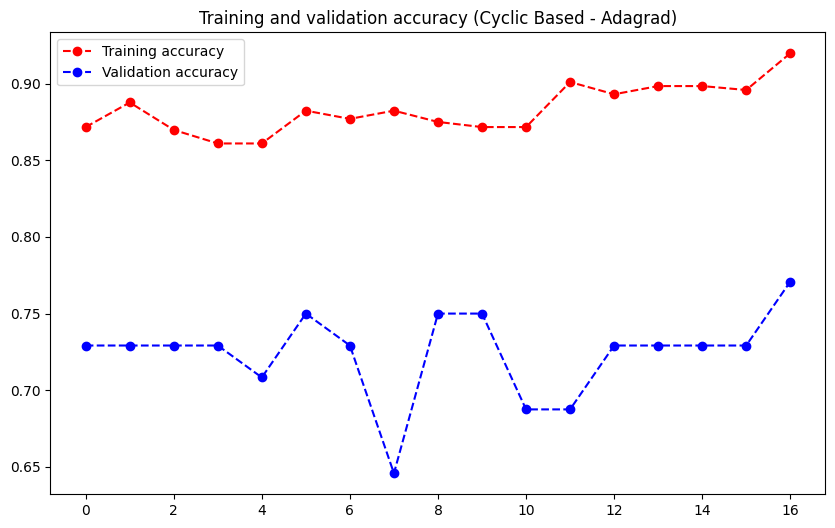

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'r', label='Training accuracy', marker = 'o', linestyle = 'dashed')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy', marker = 'o', linestyle = 'dashed')
plt.title('Training and validation accuracy (Cyclic Based - Adagrad)')
plt.legend(loc=0)

plt.show()

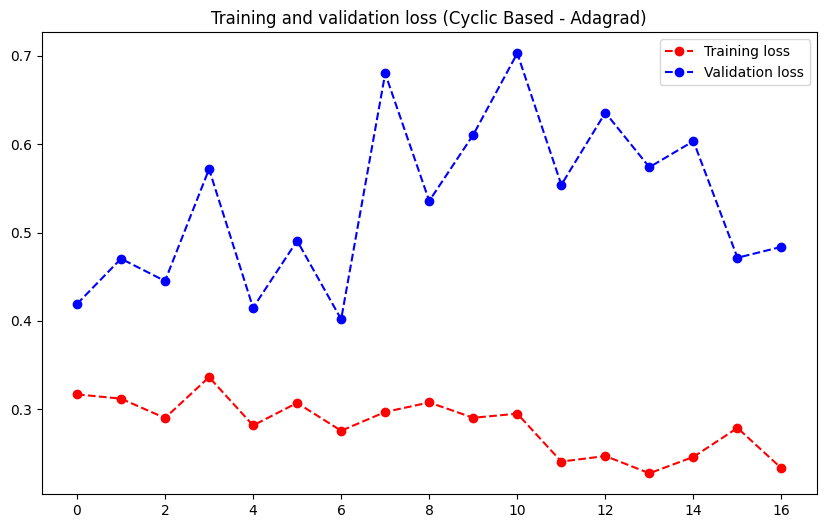

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'r', label='Training loss', marker = 'o', linestyle = 'dashed')
plt.plot(epochs, val_loss, 'b', label='Validation loss', marker = 'o', linestyle = 'dashed')
plt.title('Training and validation loss (Cyclic Based - Adagrad)')
plt.legend(loc=0)

plt.show()

### **Optimizer = RMSprop**

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=epoch,
                    steps_per_epoch=3,
                    validation_data = validation_generator,
                    verbose = 1, validation_steps=3, callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
3/3 [==============================] - 10s 3s/step - loss: 0.3647 - accuracy: 0.8698 - val_loss: 0.7830 - val_accuracy: 0.7083 - lr: 1.0000e-04
Epoch 2/100
3/3 [==============================] - 10s 3s/step - loss: 0.3027 - accuracy: 0.8877 - val_loss: 0.7186 - val_accuracy: 0.7083 - lr: 2.1250e-04
Epoch 3/100
3/3 [==============================] - 10s 4s/step - loss: 0.5427 - accuracy: 0.8128 - val_loss: 0.3363 - val_accuracy: 0.8750 - lr: 3.2500e-04
Epoch 4/100
3/3 [==============================] - 8s 3s/step - loss: 0.4119 - accuracy: 0.8235 - val_loss: 1.0520 - val_accuracy: 0.5417 - lr: 4.3750e-04
Epoch 5/100
3/3 [==============================] - 9s 3s/step - loss: 0.5813 - accuracy: 0.7326 - val_loss: 0.7520 - val_accuracy: 0.6875 - lr: 5.5000e-04
Epoch 6/100
3/3 [==============================] - 10s 3s/step - loss: 0.4097 - accuracy: 0.8177 - val_loss: 0.7784 - val_accuracy: 0.7292 - lr: 6.6250e-04
Epoch 7/100
3/3 [==============================] - 10s 4s/step - l

In [ ]:
epochs_completed = len(history.history['loss'])
print(f"Training stopped at epoch: {epochs_completed}")

Training stopped at epoch: 13


In [ ]:
RMSprop_loss = history.history['loss']
RMSprop_acc = history.history['accuracy']

print(RMSprop_loss)
print(RMSprop_acc)

[0.3646646738052368, 0.3027353286743164, 0.5427022576332092, 0.411943644285202, 0.5813143849372864, 0.4097054898738861, 0.9292468428611755, 0.6255277991294861, 0.4385446012020111, 0.9309169054031372, 0.8026108145713806, 0.6361798644065857, 0.48000654578208923]
[0.8697916865348816, 0.8877005577087402, 0.8128342032432556, 0.8235294222831726, 0.7326202988624573, 0.8177083134651184, 0.7112299203872681, 0.7540106773376465, 0.8125, 0.625668466091156, 0.625668466091156, 0.7083333134651184, 0.84375]


In [ ]:
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)
print(f"Optimizer: RMSprop, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Optimizer: RMSprop, Validation Loss: 0.5501442551612854, Validation Accuracy: 0.8030303120613098


In [ ]:
loss, accuracy = model.evaluate(train_generator, verbose=0)
print(f"Optimizer: RMSprop, Training Loss: {loss}, Training Accuracy: {accuracy}")

Optimizer: RMSprop, Training Loss: 0.34601905941963196, Training Accuracy: 0.8725099563598633


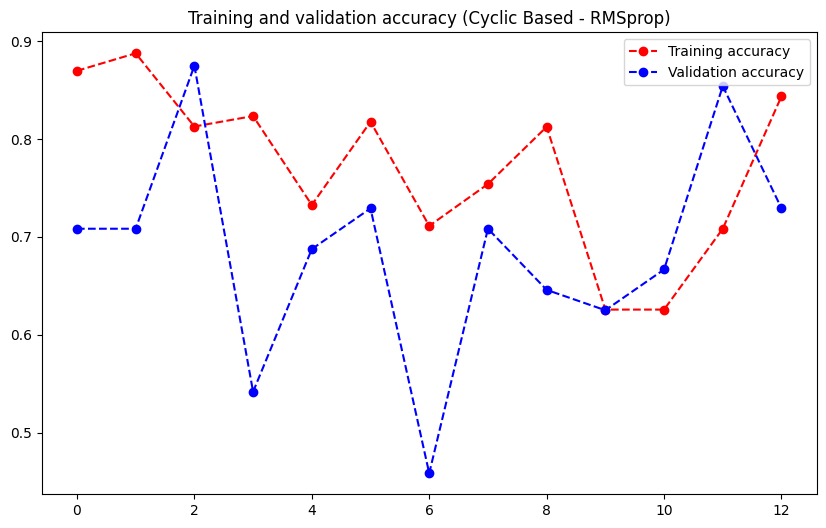

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'r', label='Training accuracy', marker = 'o', linestyle = 'dashed')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy', marker = 'o', linestyle = 'dashed')
plt.title('Training and validation accuracy (Cyclic Based - RMSprop)')
plt.legend(loc=0)

plt.show()

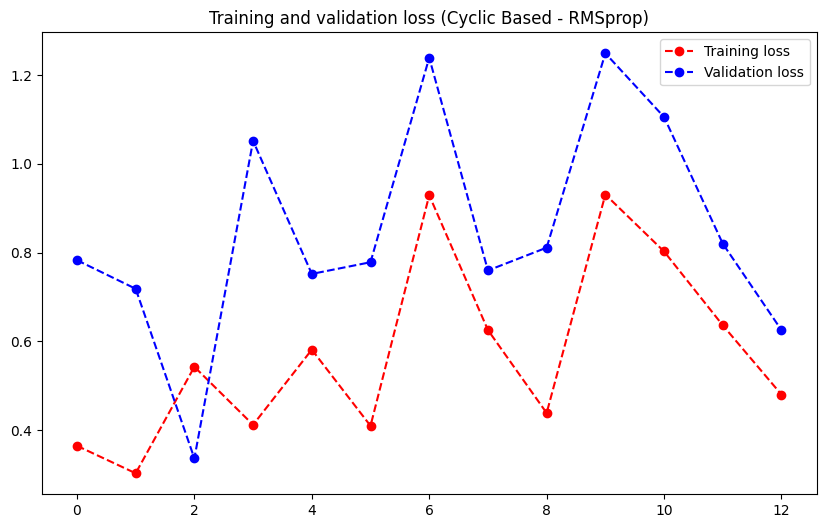

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'r', label='Training loss', marker = 'o', linestyle = 'dashed')
plt.plot(epochs, val_loss, 'b', label='Validation loss', marker = 'o', linestyle = 'dashed')
plt.title('Training and validation loss (Cyclic Based - RMSprop)')
plt.legend(loc=0)

plt.show()

### **Optimizer = SGD**

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer=SGD(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=epoch,
                    steps_per_epoch=3,
                    validation_data = validation_generator,
                    verbose = 1, validation_steps=3, callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
3/3 [==============================] - 11s 4s/step - loss: 0.3676 - accuracy: 0.8556 - val_loss: 0.5454 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 2/100
3/3 [==============================] - 8s 3s/step - loss: 0.3081 - accuracy: 0.9037 - val_loss: 0.5614 - val_accuracy: 0.8333 - lr: 2.1250e-04
Epoch 3/100
3/3 [==============================] - 9s 3s/step - loss: 0.2332 - accuracy: 0.9144 - val_loss: 0.5441 - val_accuracy: 0.8542 - lr: 3.2500e-04
Epoch 4/100
3/3 [==============================] - 9s 3s/step - loss: 0.2577 - accuracy: 0.8984 - val_loss: 0.3992 - val_accuracy: 0.8542 - lr: 4.3750e-04
Epoch 5/100
3/3 [==============================] - 9s 3s/step - loss: 0.2633 - accuracy: 0.8906 - val_loss: 0.5120 - val_accuracy: 0.8542 - lr: 5.5000e-04
Epoch 6/100
3/3 [==============================] - 7s 3s/step - loss: 0.2235 - accuracy: 0.9305 - val_loss: 0.5203 - val_accuracy: 0.8125 - lr: 6.6250e-04
Epoch 7/100
3/3 [==============================] - 9s 3s/step - loss:

In [ ]:
epochs_completed = len(history.history['loss'])
print(f"Training stopped at epoch: {epochs_completed}")

Training stopped at epoch: 14


In [ ]:
SGD_loss = history.history['loss']
SGD_acc = history.history['accuracy']

print(SGD_loss)
print(SGD_acc)

[0.3676186501979828, 0.3081311583518982, 0.2331751435995102, 0.25773513317108154, 0.26327624917030334, 0.2234700471162796, 0.2527408003807068, 0.28823739290237427, 0.31468331813812256, 0.3444516956806183, 0.2898162603378296, 0.31591060757637024, 0.25146982073783875, 0.26679396629333496]
[0.855614960193634, 0.903743326663971, 0.9144384860992432, 0.8983957171440125, 0.890625, 0.9304812550544739, 0.8983957171440125, 0.8716577291488647, 0.8877005577087402, 0.859375, 0.903743326663971, 0.8877005577087402, 0.8983957171440125, 0.8823529481887817]


In [ ]:
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)
print(f"Optimizer: SGD, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Optimizer: SGD, Validation Loss: 0.5082273483276367, Validation Accuracy: 0.8333333134651184


In [ ]:
loss, accuracy = model.evaluate(train_generator, verbose=0)
print(f"Optimizer: SGD, Training Loss: {loss}, Training Accuracy: {accuracy}")

Optimizer: SGD, Training Loss: 0.26409006118774414, Training Accuracy: 0.9003984332084656


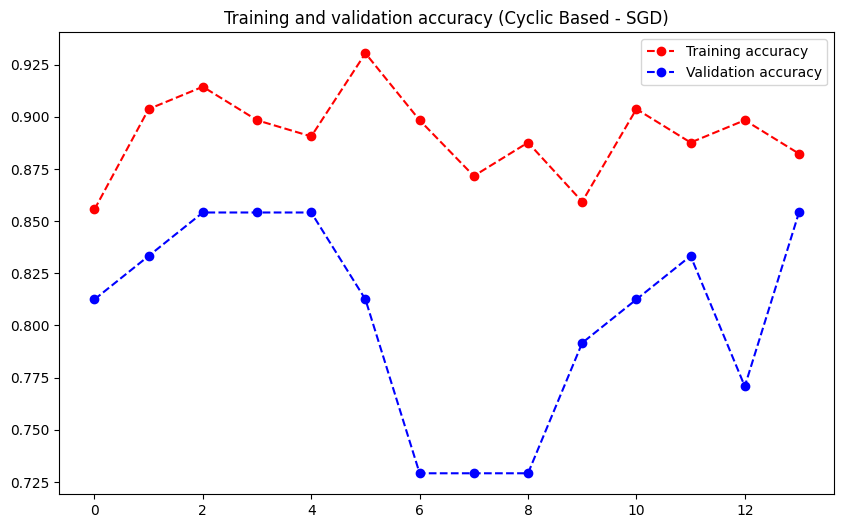

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'r', label='Training accuracy', marker = 'o', linestyle = 'dashed')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy', marker = 'o', linestyle = 'dashed')
plt.title('Training and validation accuracy (Cyclic Based - SGD)')
plt.legend(loc=0)

plt.show()

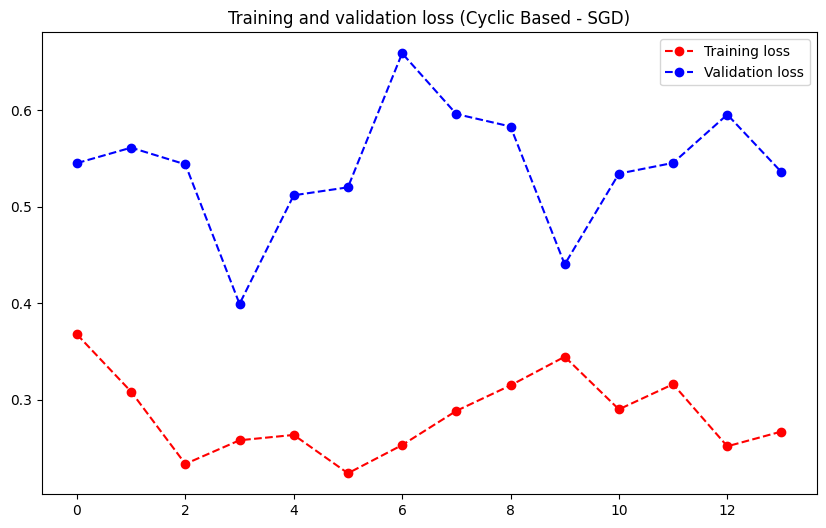

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'r', label='Training loss', marker = 'o', linestyle = 'dashed')
plt.plot(epochs, val_loss, 'b', label='Validation loss', marker = 'o', linestyle = 'dashed')
plt.title('Training and validation loss (Cyclic Based - SGD)')
plt.legend(loc=0)

plt.show()

### **Combined**

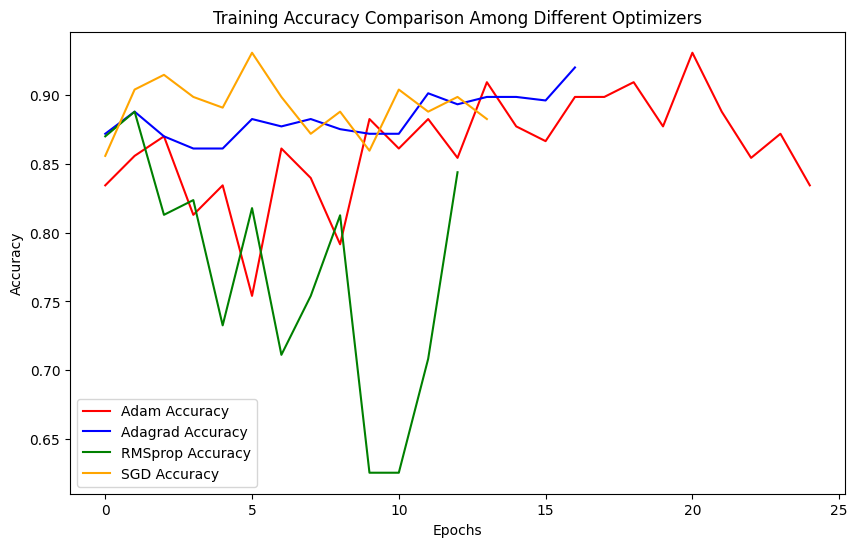

In [ ]:
plt.figure(figsize=(10, 6))

# Plot each accuracy list. Use range(len(acc_list)) for the x-axis
plt.plot(range(len(Adam_acc)), Adam_acc, 'red', label='Adam Accuracy')
plt.plot(range(len(Adagrad_acc)), Adagrad_acc, 'blue', label='Adagrad Accuracy')
plt.plot(range(len(RMSprop_acc)), RMSprop_acc, 'green', label='RMSprop Accuracy')
plt.plot(range(len(SGD_acc)), SGD_acc, 'orange', label='SGD Accuracy')

plt.title('Training Accuracy Comparison Among Different Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')  # Adjusts the legend position

plt.show()